In [1]:
#from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../msrv-xc/')
sys.path.append('../wdtools')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c

#import wdtools
import msrvxc
import pickle

test


In [2]:
with open('../msrv-xc/grids/interp_bosz.pkl', 'rb') as f:
    interp_bosz = pickle.load(f)
    
with open('../msrv-xc/grids/interp_bosz_norm.pkl', 'rb') as f:
    interp_bosz_norm = pickle.load(f)
    
wvl = np.load('../msrv-xc/grids/wavl.npy')

In [3]:
from astropy.table import Table, vstack

ms_sdss4_wd_sdss4 = Table.read('data/ms_sdss4_wd_sdss4.fits')
ms_gaia_wd_sdss4 = Table.read('data/ms_gaia_wd_sdss4.fits')
#ms_sdss5_wd_sdss4 = Table.read('sdss5/ms_sdss5_wd_sdss4.fits')
#
#ms_gaia_wd_sdss5 = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
#ms_sdss5_wd_sdss5 = Table.read('sdss5/ms_sdss5_wd_sdss5.fits')

def strip(catalog):  
    drop_cols = []
    keep_cols = ['ms_source_id', 'ms_plate', 'ms_mjd', 'ms_fiberid', 'radial_velocity', 'radial_velocity_error']
        
    for key in catalog.keys():
        if key not in keep_cols:
            drop_cols.append(key)
            
    catalog.remove_columns(drop_cols)
    
    return catalog

ms_sdss4_wd_sdss4 = strip(ms_sdss4_wd_sdss4)
ms_gaia_wd_sdss4  = strip(ms_gaia_wd_sdss4 )
#ms_sdss5_wd_sdss4 = strip(ms_sdss5_wd_sdss4)
#ms_gaia_wd_sdss5  = strip(ms_gaia_wd_sdss5 )
#ms_sdss5_wd_sdss5 = strip(ms_sdss5_wd_sdss5)

catalog = vstack([ms_sdss4_wd_sdss4, ms_gaia_wd_sdss4])#, ms_sdss5_wd_sdss4, ms_gaia_wd_sdss5, ms_sdss5_wd_sdss5])

In [4]:
print(len(catalog[catalog['radial_velocity'].mask]))

19


In [5]:
catalog[['radial_velocity', 'radial_velocity_error']]

radial_velocity,radial_velocity_error
km / s,km / s
float32,float32
--,--
--,--
--,--
--,--
--,--
--,--
--,--
--,--


In [6]:
c_kms = 2.99792458e5 # speed of light in km/s


def continuum_normalize(wl, fl, ivar = None, avg_size = 150, ret_cont = False):
    
    fl_norm = np.zeros(np.size(fl))
    fl_cont = np.zeros(np.size(fl))
    
    ivar_yes = 0
    if ivar is not None:
        ivar_yes = 1
        ivar_norm = np.zeros(np.size(fl))
        
    for i in range(np.size(wl)):
        wl_clip = ((wl[i]-avg_size/2)<wl) * (wl<(wl[i]+avg_size/2))
        fl_cont[i] = np.median(fl[wl_clip])
        if ivar_yes:
            ivar_norm[i] = ivar[i]*np.median(fl[wl_clip])**2
    
    fl_norm = fl/fl_cont
    
    if ret_cont:
        if ivar_yes:
            return wl, fl_norm, ivar_norm, fl_cont
        else:
            return wl, fl_norm, fl_cont
    else:
        if ivar_yes:
            return wl, fl_norm, ivar_norm
        else:
            return wl, fl_norm
        
def simulate_spec(interpolator, interp_wvl, wl, params):
    teff, logg, Z, rv = (params['teff'], params['logg'], params['z'], params['RV'])
    
    wl = wl * np.sqrt((1 - rv/c_kms)/(1 + rv/c_kms))
    
    return wl, np.interp(wl, interp_wvl, interpolator( (teff, logg, Z, 0) ))

  0%|                                                                                           | 0/173 [00:00<?, ?it/s]

0.0437566033927971
-15.740600217639347
5637.168115657814


  1%|▍                                                                                  | 1/173 [00:08<23:01,  8.03s/it]

0.006810897349641808
-1.0050576999280376
1000.9193664143173


  1%|▉                                                                                  | 2/173 [00:14<20:23,  7.15s/it]

3.414250853868925e-05
-0.0032613188592924424
1421.6508515704088


  2%|█▍                                                                                 | 3/173 [00:21<19:30,  6.89s/it]

0.00011783217466379882
-0.014030334010588764
927.6086326951024


  2%|█▉                                                                                 | 4/173 [00:27<18:50,  6.69s/it]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


0.0003844891712556102
-0.09670238435600505
826.0287632147841


  3%|██▍                                                                                | 5/173 [00:34<18:41,  6.68s/it]

0.06902157929600353
2.1383273645899084
1805.8862615232872


  3%|██▉                                                                                | 6/173 [00:41<19:21,  6.95s/it]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


0.01874101346759383
1.401628691658588
1229.1513553640043


  4%|███▎                                                                               | 7/173 [00:49<20:05,  7.26s/it]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


0.005395171875633859
0.08814967328564359
962.3189028241121


  5%|███▊                                                                               | 8/173 [00:56<19:49,  7.21s/it]

0.001904950712395641
-0.05027376966369258
836.5312139399391


  6%|████▋                                                                             | 10/173 [01:03<14:43,  5.42s/it]

0.08995018778477767
0.3483687993005094
7700.643537089607


  6%|█████▏                                                                            | 11/173 [01:10<15:57,  5.91s/it]

7.600472014155732e-05
-0.19175617067552408
1182.9895538378705


/home/arseneau/research/white-dwarfs/gravitational-redshift/../msrv-xc/msrvxc/fit.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,5))
  7%|█████▋                                                                            | 12/173 [01:19<17:41,  6.60s/it]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


0.253620941701443
-26.42088903654305
3134.813632821971


  8%|██████▏                                                                           | 13/173 [01:26<17:55,  6.72s/it]

0.6635940844464653
-44.05319419434263
17057.28913473387


  8%|██████▋                                                                           | 14/173 [01:33<17:51,  6.74s/it]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


0.00020577901276783798
-0.0371458865072587
721.6546116056813


  9%|███████                                                                           | 15/173 [01:41<18:53,  7.18s/it]

4.004528441019604e-05
-0.09769319784175395
1199.72409769425


  9%|███████▌                                                                          | 16/173 [01:49<19:27,  7.44s/it]

0.00013101579930973624
-0.010462295688964092
868.9106707776946


 10%|████████                                                                          | 17/173 [01:56<18:46,  7.22s/it]

0.023605834094517532
0.9735173494055406
3720.391403025814


 10%|████████▌                                                                         | 18/173 [02:03<18:32,  7.18s/it]

0.02797605110075619
3.0054601186372754
1998.9877688696151


 11%|█████████                                                                         | 19/173 [02:11<18:51,  7.35s/it]

0.0002293113372448248
0.01972559909358901
969.3354475691576


100%|█████████████████████████████████████████████████████████████████████████████████| 173/173 [02:18<00:00,  1.25it/s]


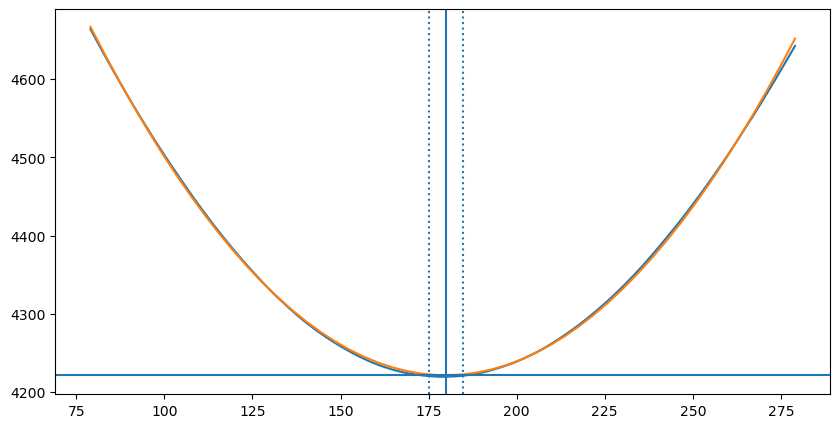

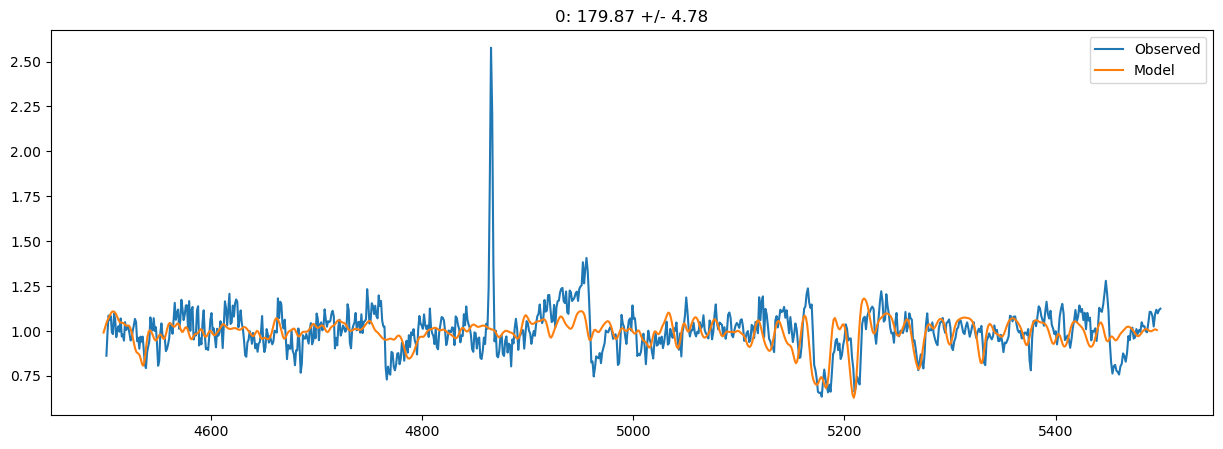

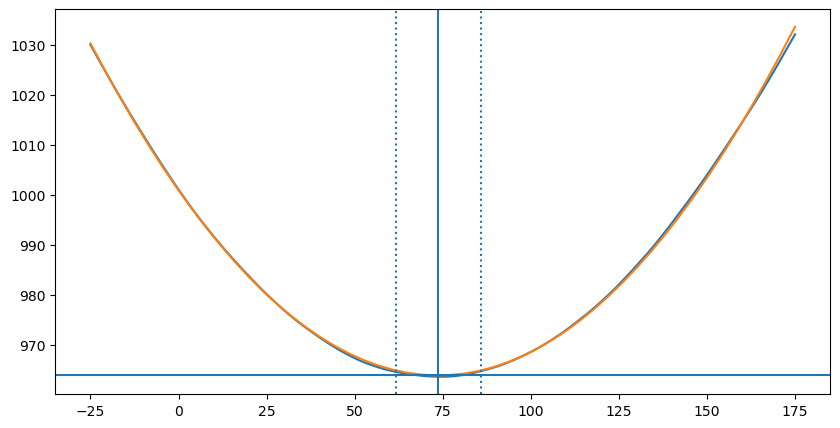

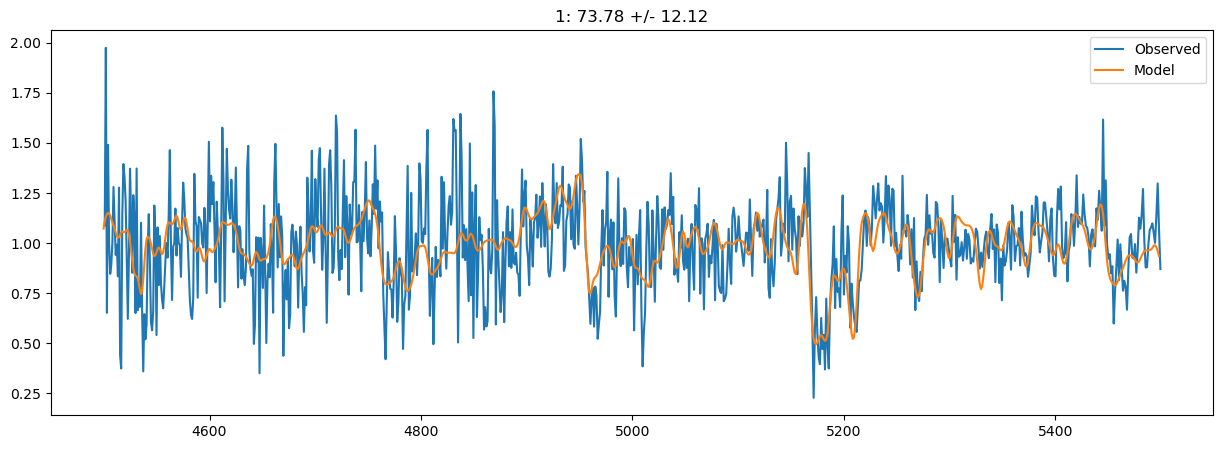

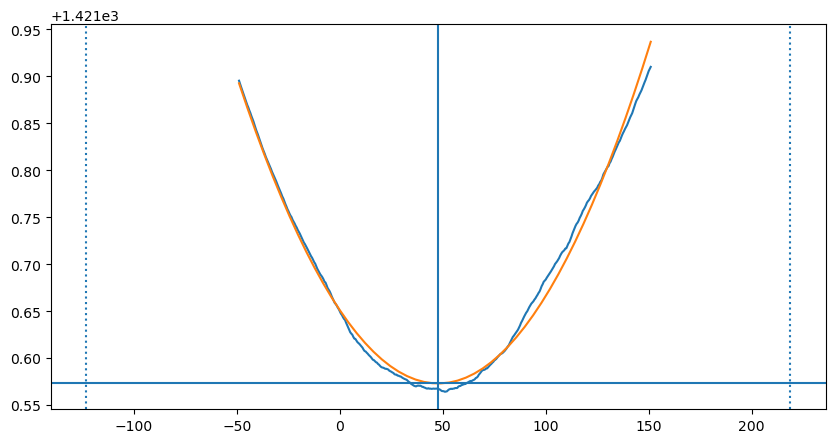

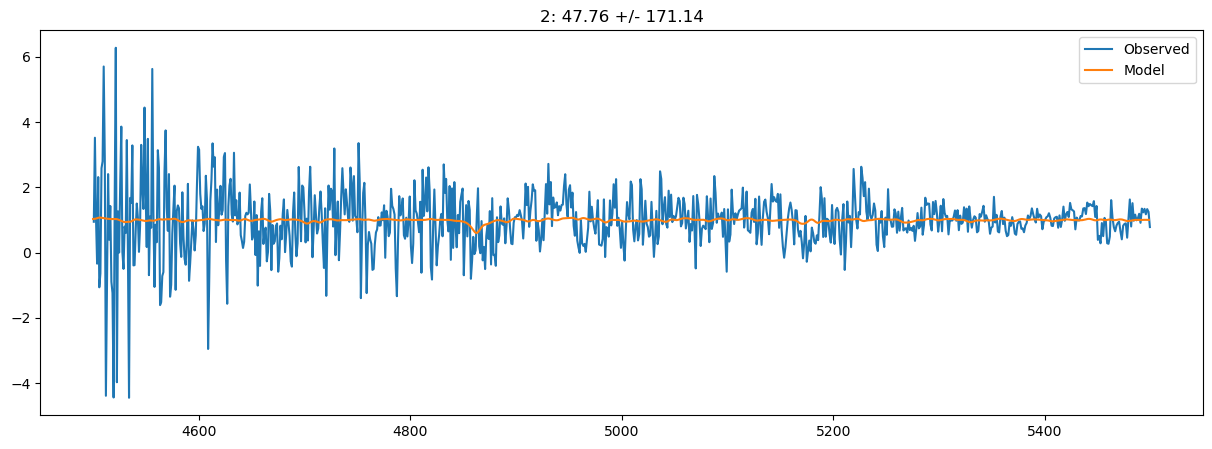

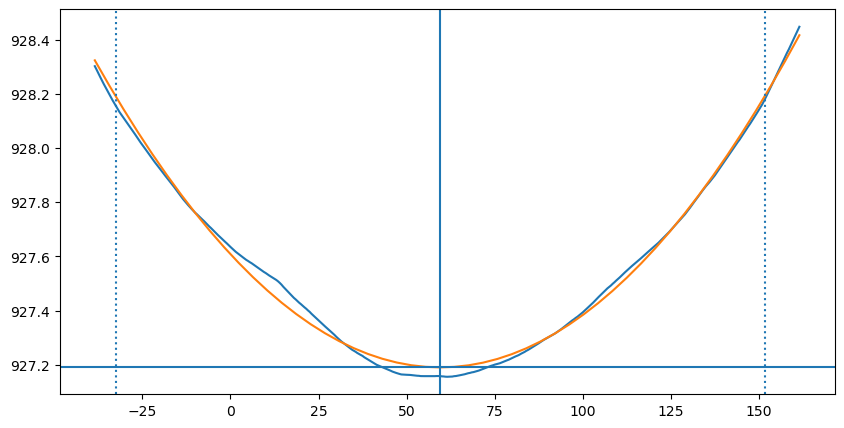

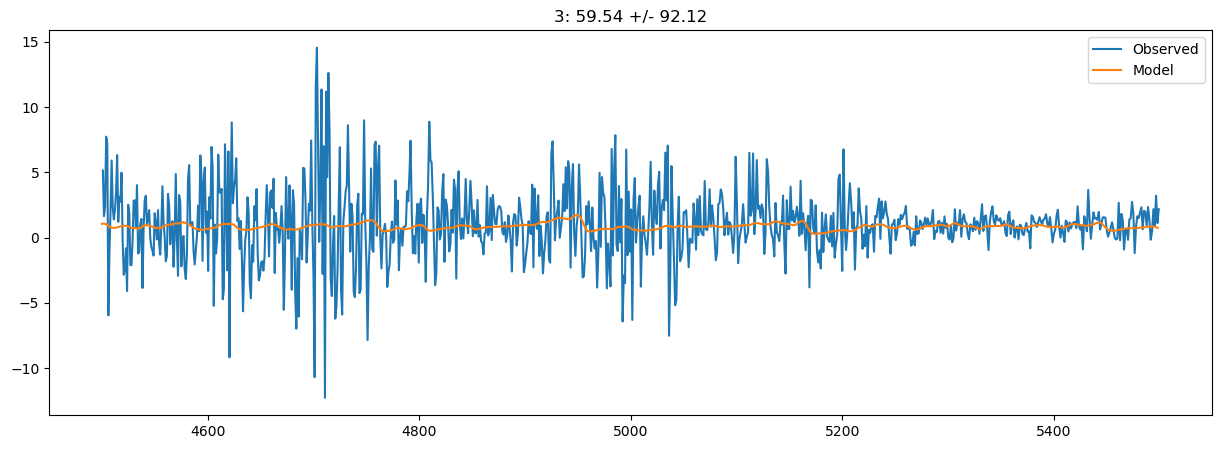

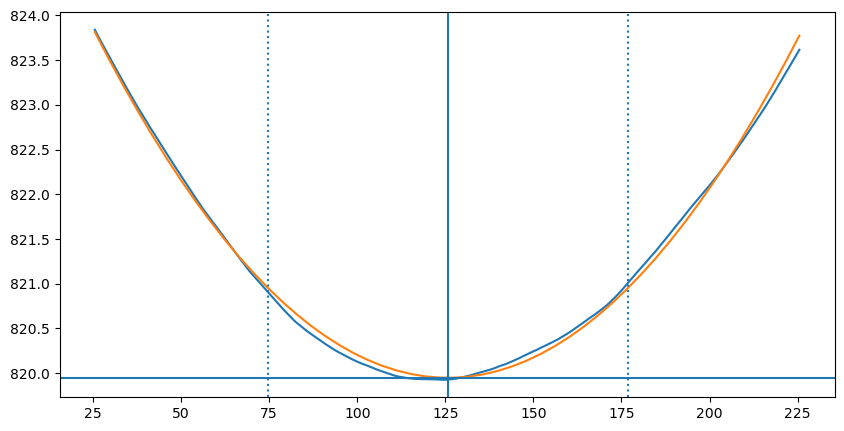

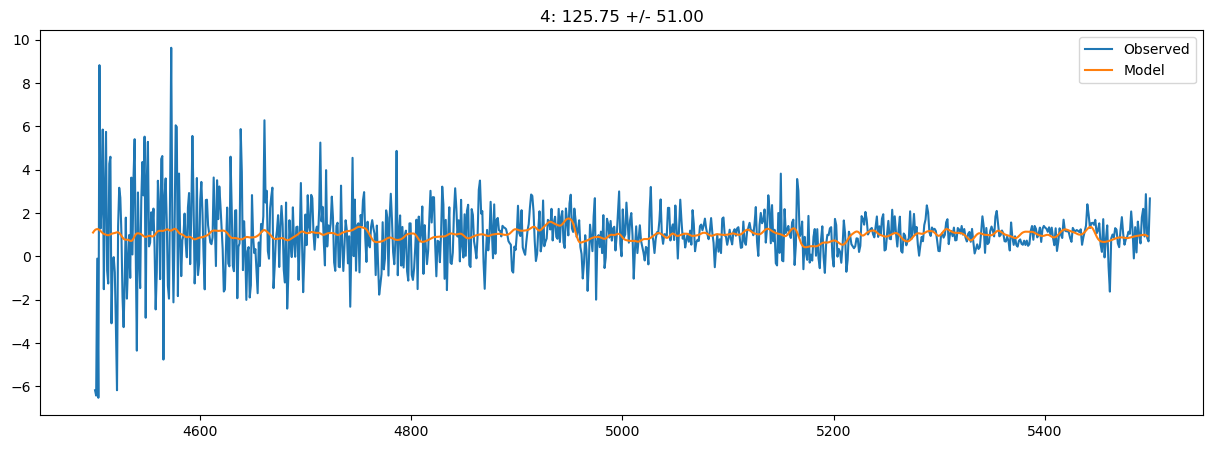

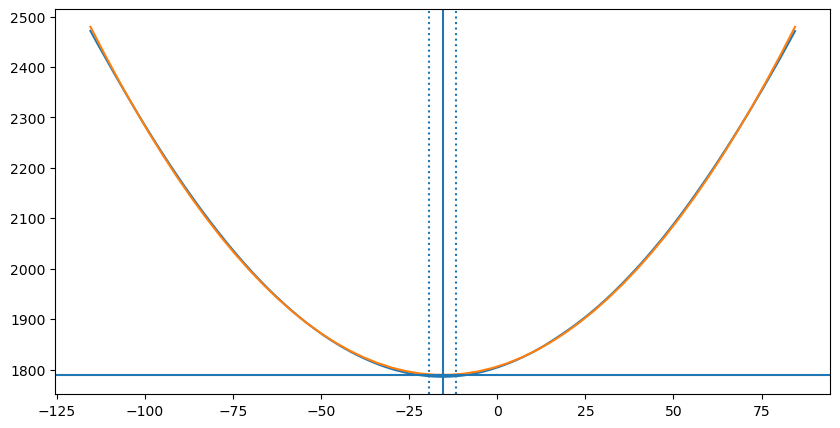

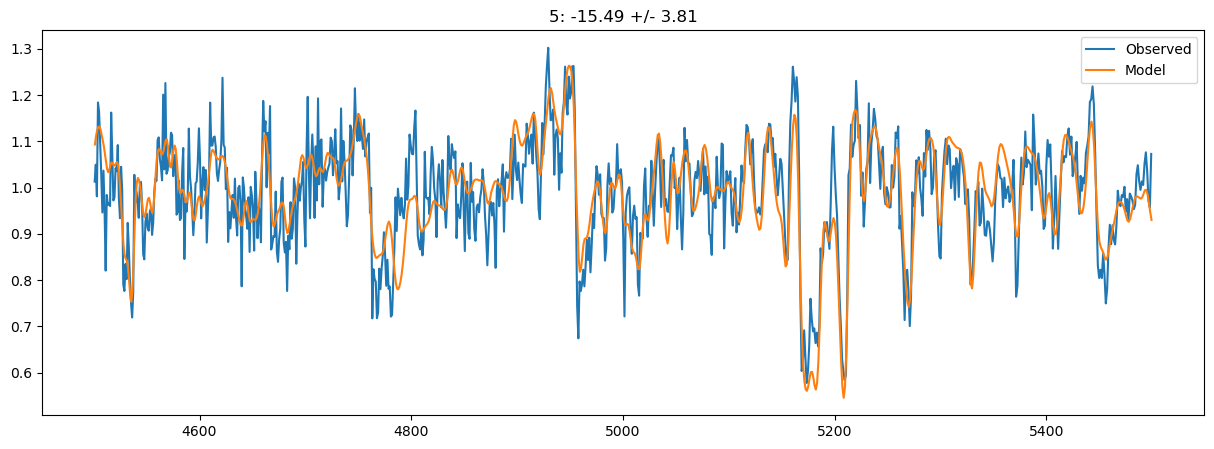

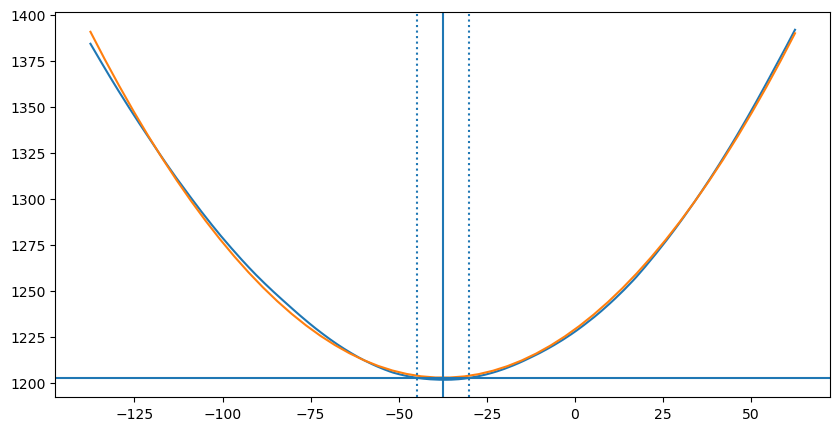

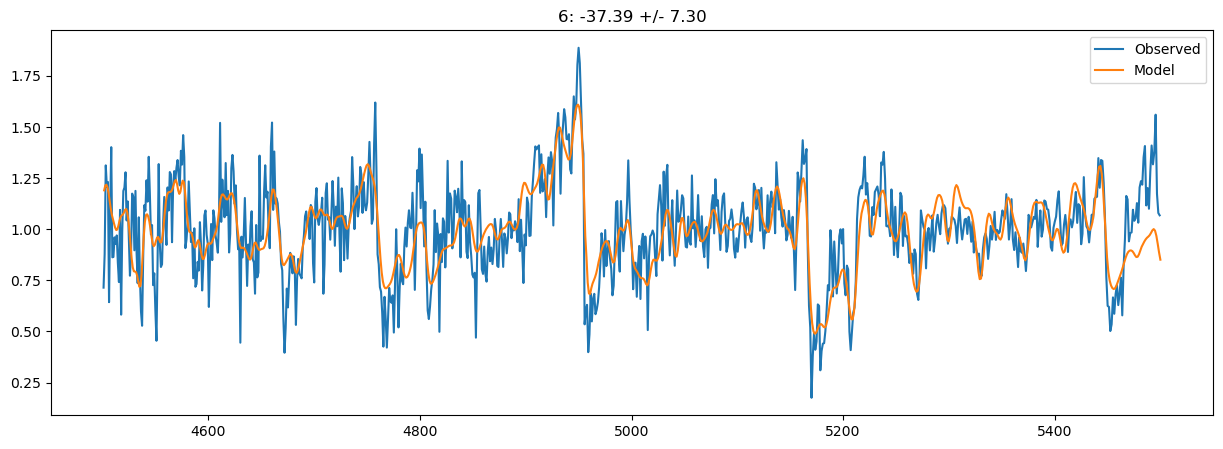

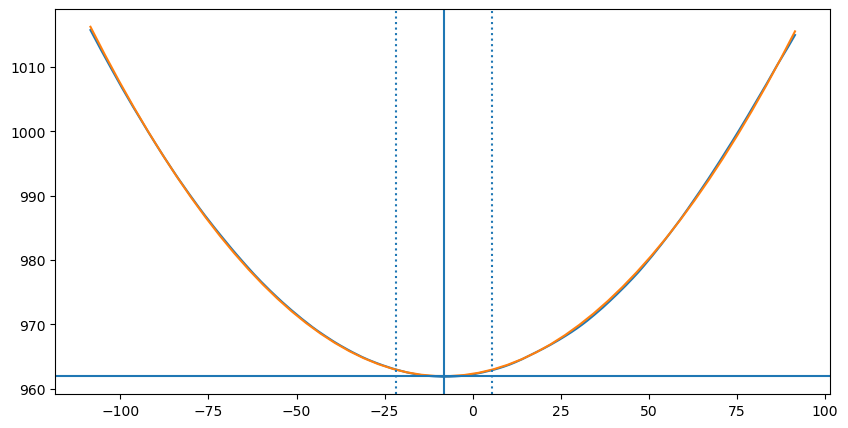

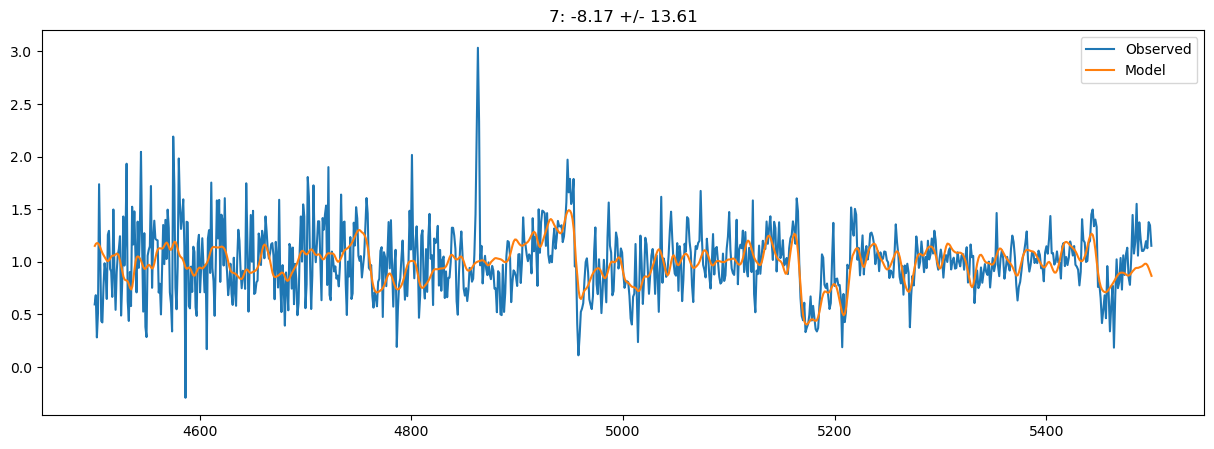

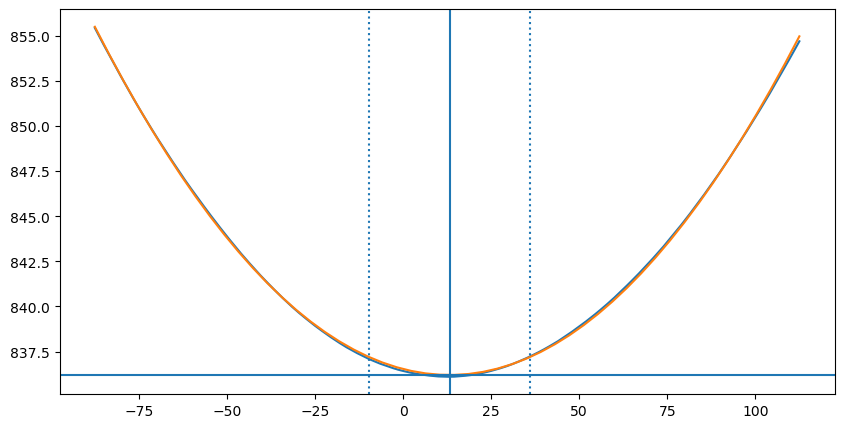

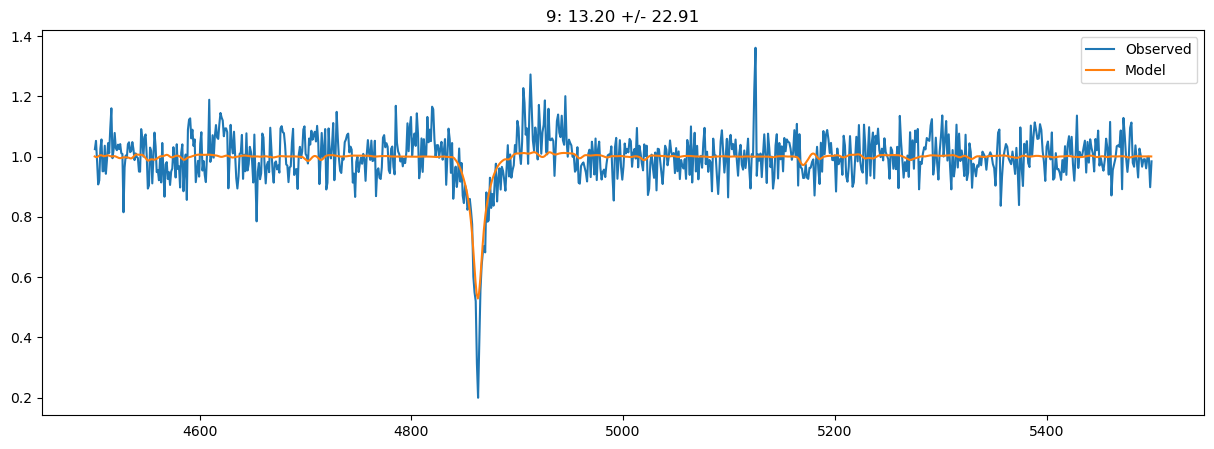

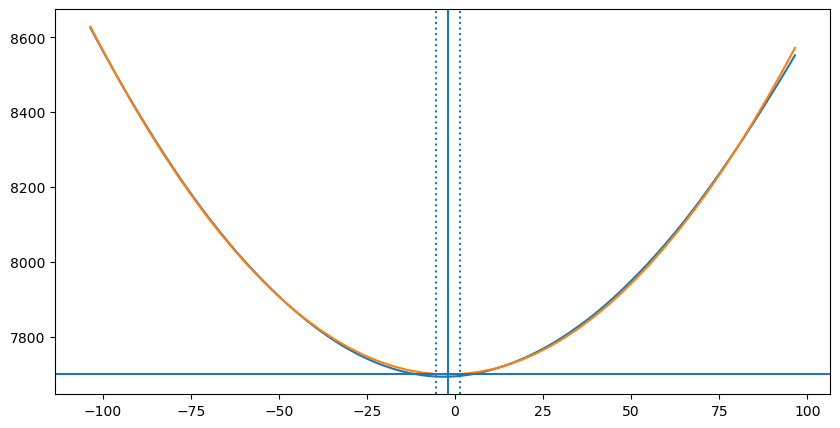

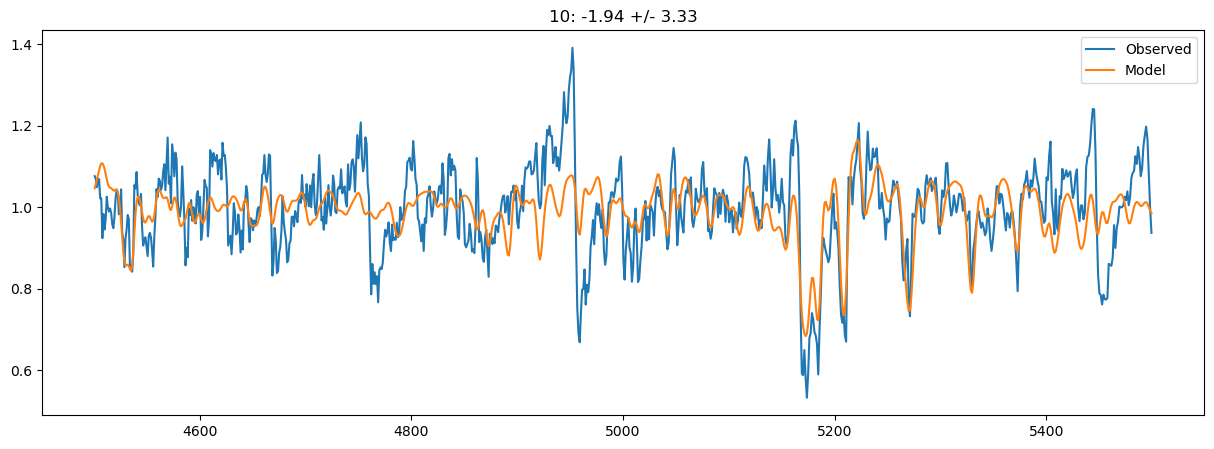

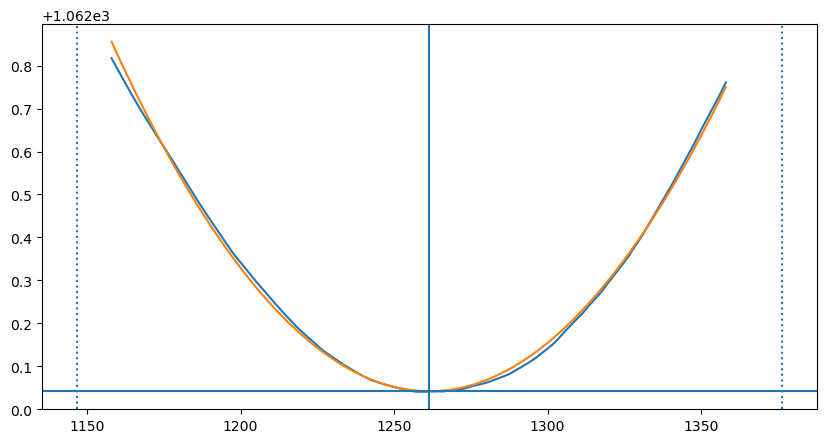

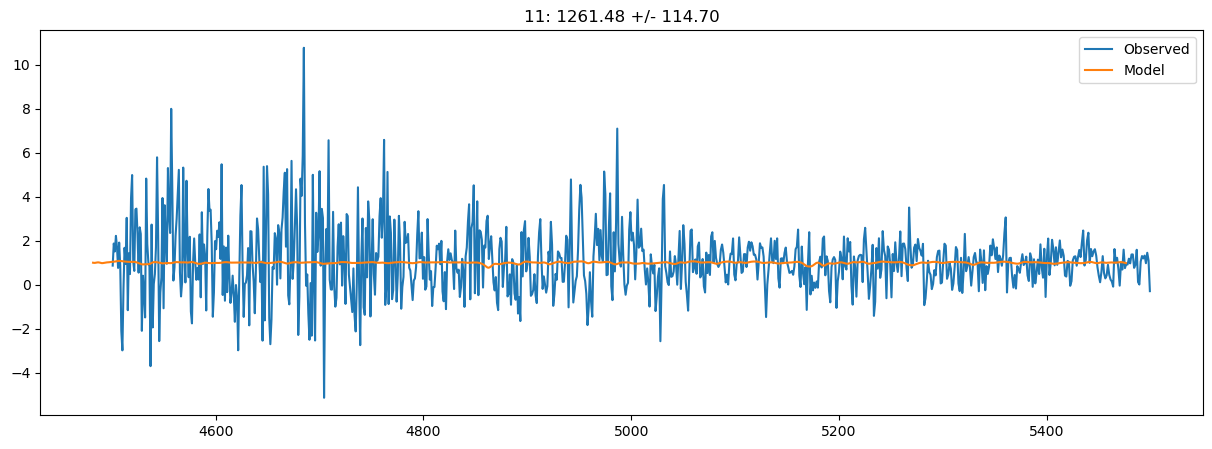

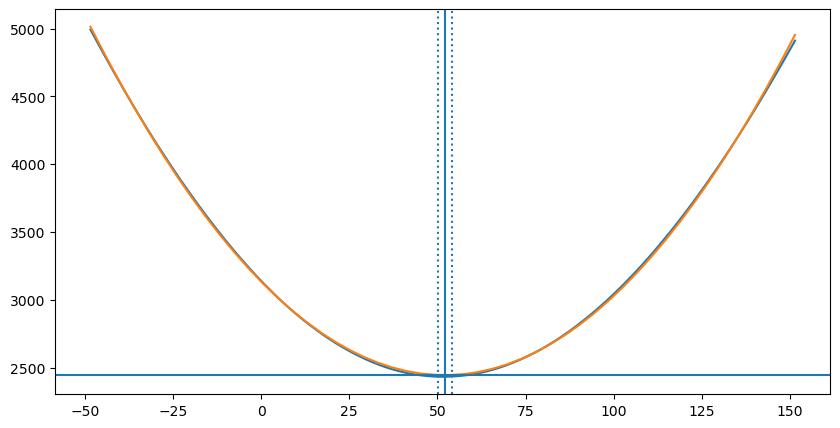

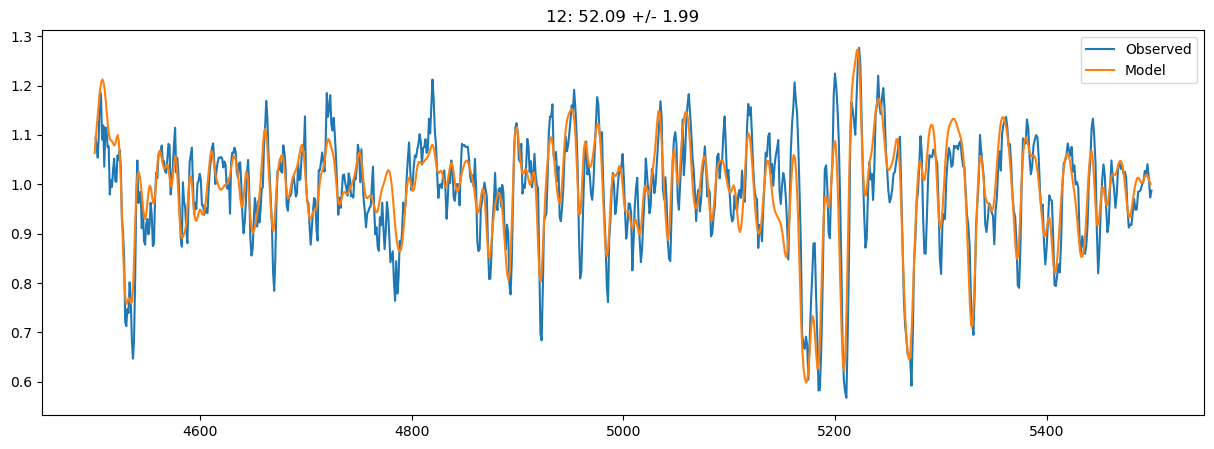

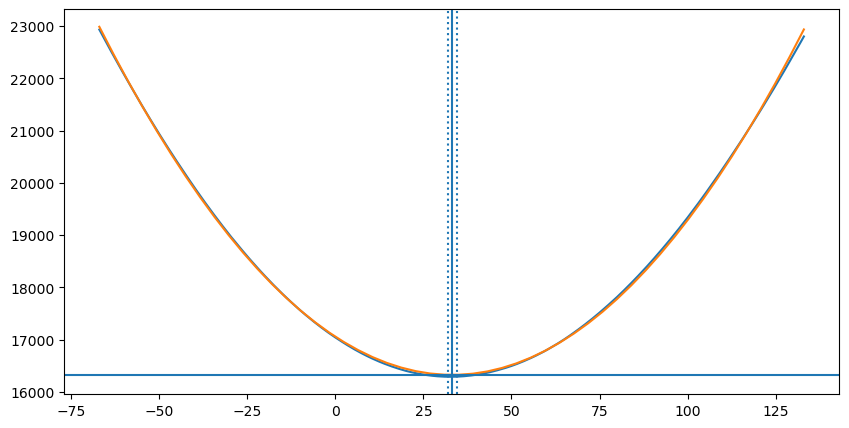

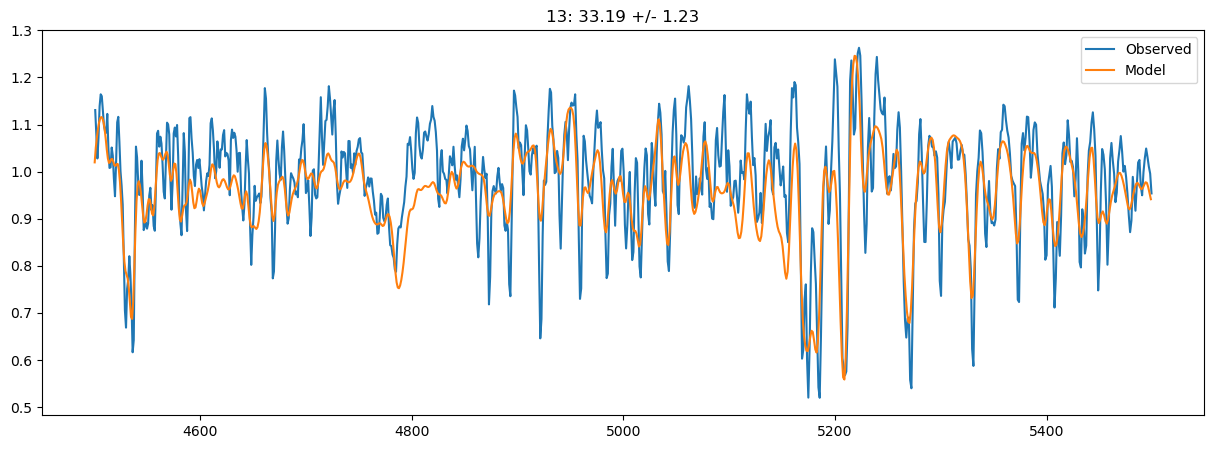

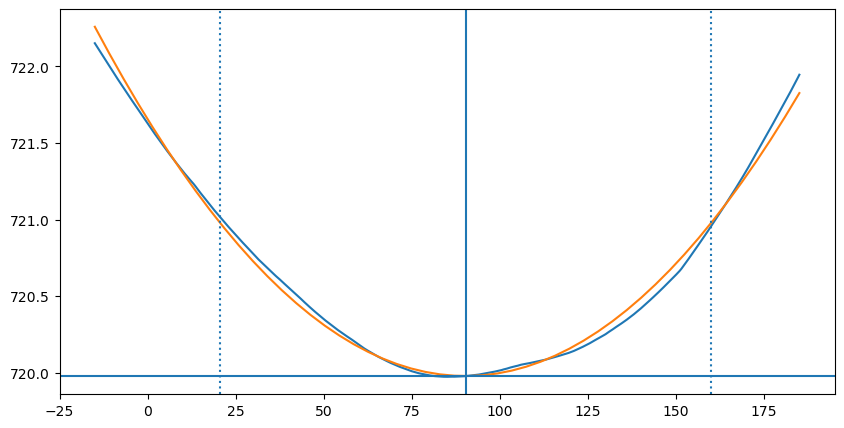

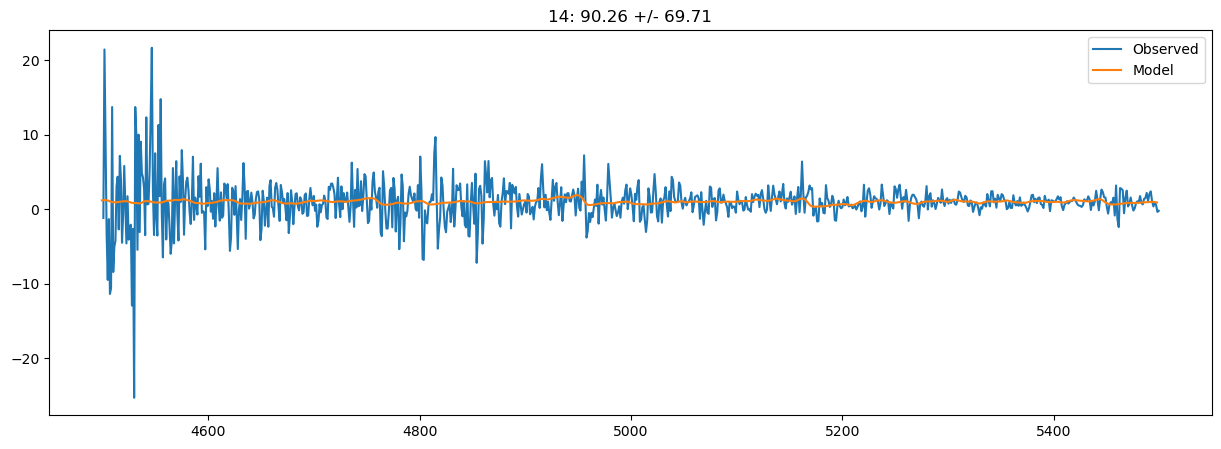

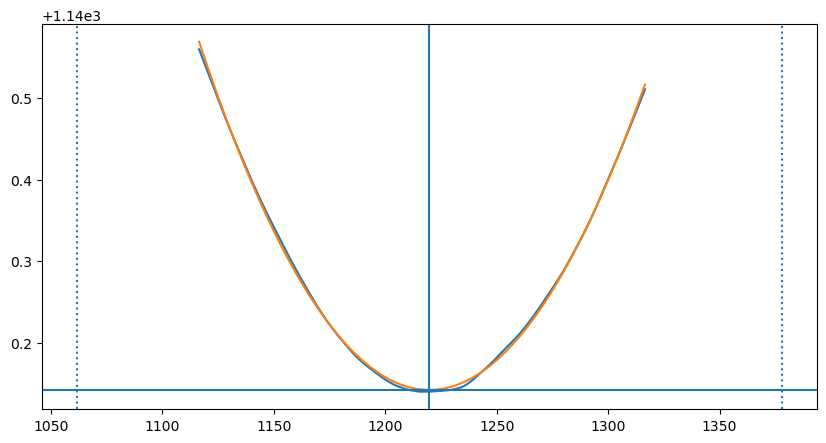

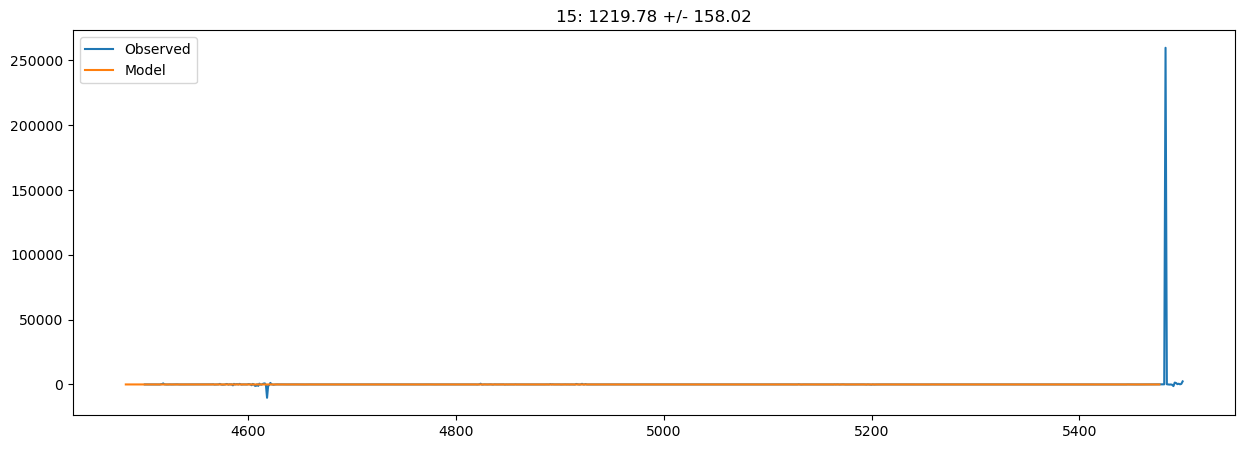

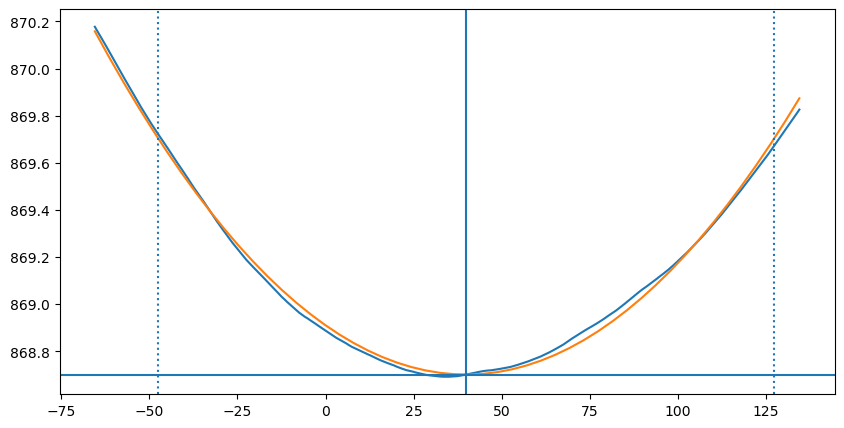

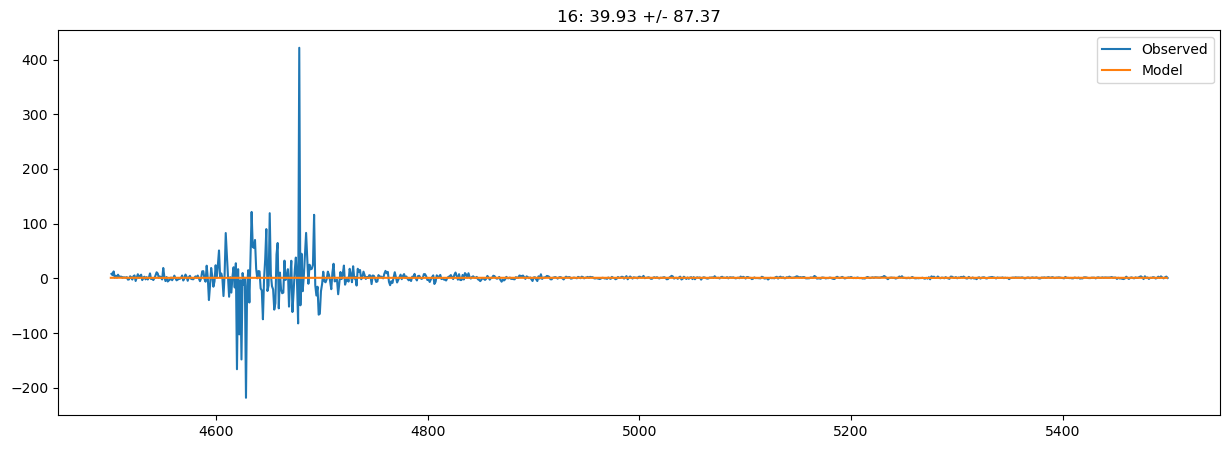

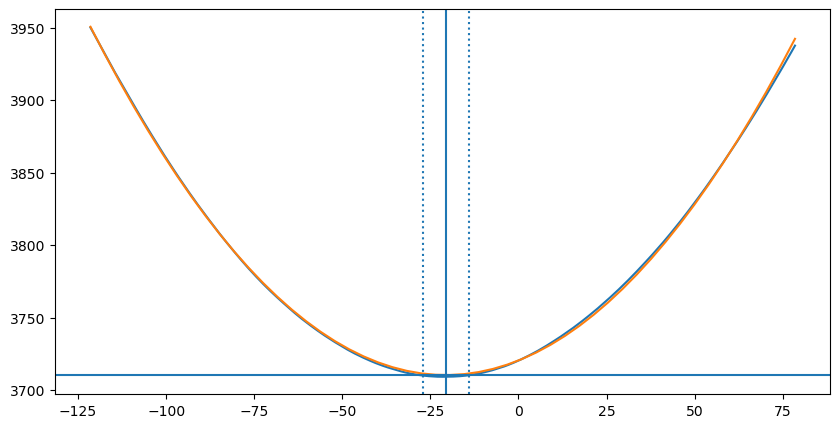

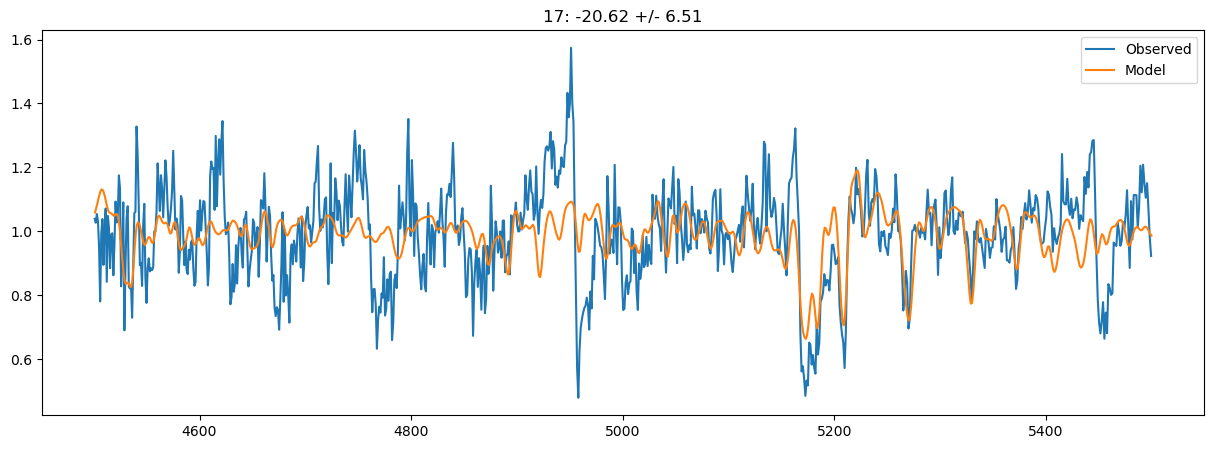

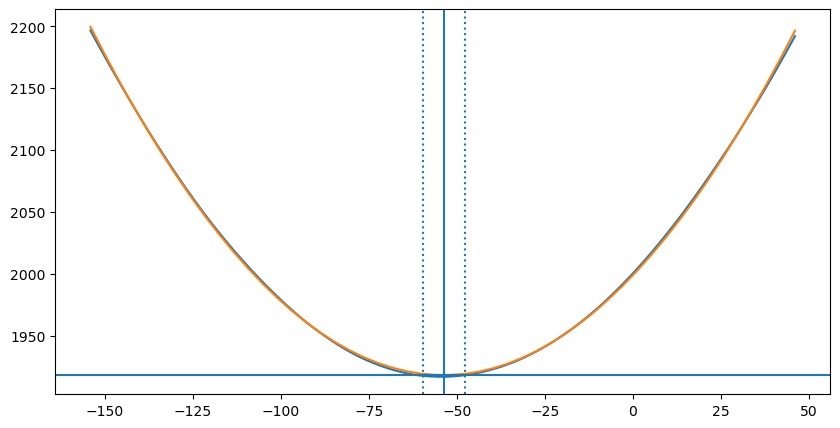

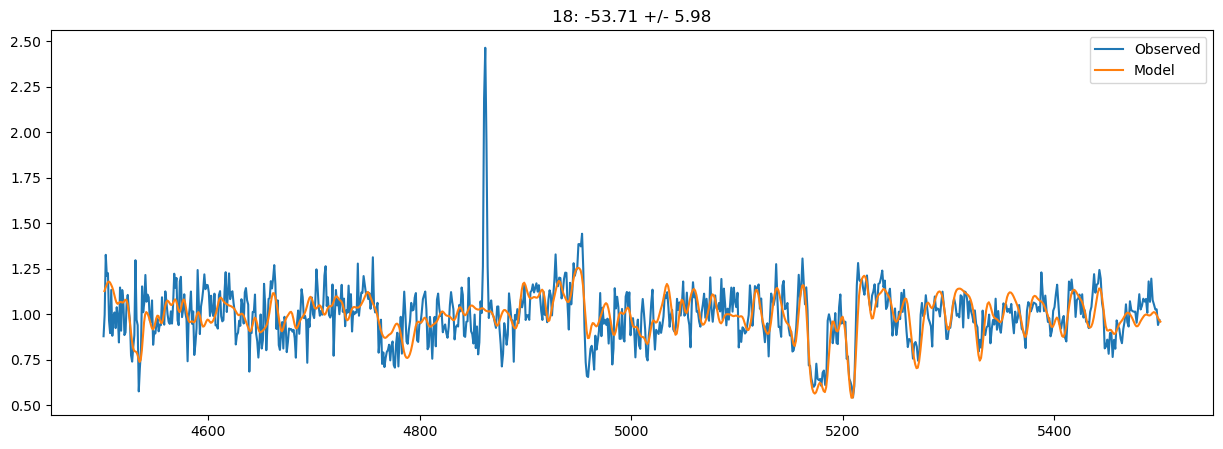

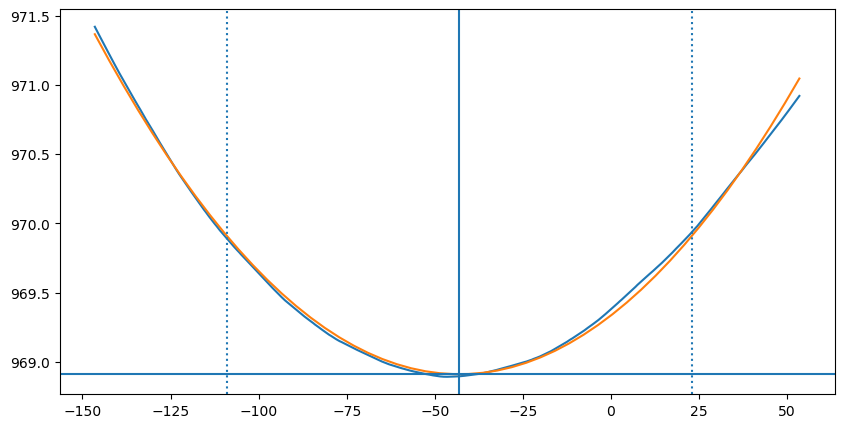

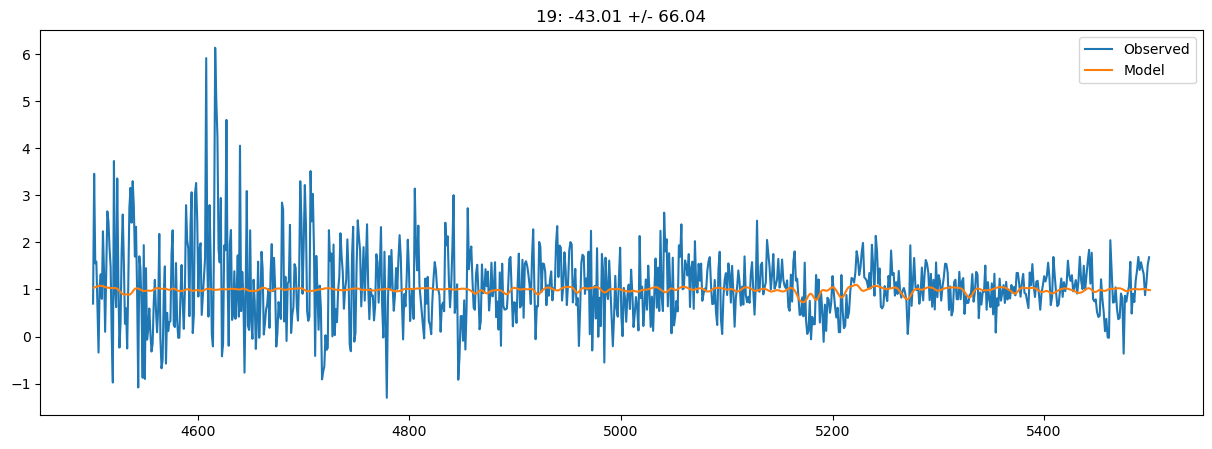

In [7]:
drops = []
catalog['ms_redchi'] = np.zeros(len(catalog))
catalog['ms_gaia'] = np.ones(len(catalog))
catalog['ms_catalog_id'] = np.zeros(len(catalog))

for i in tqdm(range(len(catalog))):
    catalog['ms_catalog_id'] = i
    if catalog['radial_velocity'].mask[i]:
        #try:
        spec = SDSS.get_spectra(plate=catalog['ms_plate'][i], fiberID=catalog['ms_fiberid'][i], mjd=catalog['ms_mjd'][i])[0]
    
        wl = (10**spec[1].data['loglam'])
        fl = (spec[1].data['flux'])
        ivar = (spec[1].data['ivar'])
        
        wl, fl, ivar = continuum_normalize(wl, fl, ivar)
        
        mask = (4500 < wl)*(wl < 5500)
        
        rv, e_rv, redchi, res = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wl[mask], fl[mask], ivar[mask], plot = True)
        
        plt.figure(figsize = (15,5))

        #plt.subplot(1,2,1)
        
        res.params['RV'].value = rv
        
        nwl, nfl = msrvxc.utils.continuum_normalize(wl, fl)
        plt.plot(nwl[mask], nfl[mask], label = 'Observed')
        swl, sfl = simulate_spec(interp_bosz_norm, wvl, wl, res.params)
        plt.plot(swl[mask], sfl[mask], alpha = 1, label = 'Model')
        
        plt.title('{}: {:2.2f} +/- {:2.2f}'.format(i, rv, e_rv))
        
        plt.legend()
        plt.savefig('spectra/msfits/{}.png'.format(i))
        
        catalog['radial_velocity'][i] = rv
        catalog['radial_velocity_error'][i] = e_rv
        catalog['ms_redchi'][i] = redchi
        catalog['ms_gaia'][i] = 0
        #except:
        #    print('err')
        #    drops.append(i)
            


In [8]:
catalog[['radial_velocity', 'radial_velocity_error', 'ms_redchi']]

radial_velocity,radial_velocity_error,ms_redchi
km / s,km / s,
float32,float32,float64
179.86543,4.780554,4.850223654773543
73.78306,12.117076,1.1075635780604505
47.760387,171.1403,1.6339852207566503
59.53524,92.12299,1.0656999927169168
125.754364,50.99856,0.942445153968263
-15.490281,3.8063397,2.0525213459688785
-37.394688,7.304718,1.381365048141844
-8.169311,13.614364,1.1055930210984042


In [9]:
catalog.write('data/04_ms_rv.fits', overwrite = True)

In [10]:
print(np.isnan(catalog['radial_velocity_error']))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa